In [24]:
import os

In [25]:
EPOCHS = 30
BATCH_SIZE = 8
BUFFER_SIZE = 100
TRAIN_TEST_RATIO = 0.8

In [26]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Concatenate, Input, ReLU, Dropout, Add, LayerNormalization, ZeroPadding2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Paths to noisy and clean image directories
noise_categories = {
    "Gaussian Noise": "/kaggle/input/5000-datasets/Mod_Final_data/Normalized_image/Gaussian",
    "Speckle Noise": "/kaggle/input/5000-datasets/Mod_Final_data/Normalized_image/Speckle",
    "Salt and Pepper Noise": "/kaggle/input/5000-datasets/Mod_Final_data/Normalized_image/Salt_pepper",
    "Poisson Noise": "/kaggle/input/5000-datasets/Mod_Final_data/Normalized_image/Poisson",
    "Motion Blur Noise": "/kaggle/input/5000-datasets/Mod_Final_data/Normalized_image/Motion"
}
clean_image_path = "/kaggle/input/5000-datasets/Mod_Final_data/Clean_image"


In [ ]:
# Function to load and preprocess images
def load_images(noise_categories, clean_image_path, limit=None):
    X, y = [], []
    
    for category, path in noise_categories.items():
        print(f"Processing category: {category}")
        noise_images = os.listdir(path)[:limit] if limit else os.listdir(path)
        
        for noise_image in noise_images:
            try:
                # Load noisy image
                noise_img_path = os.path.join(path, noise_image)
                noise_img = img_to_array(load_img(noise_img_path, target_size=(256, 256))) / 255.0
                X.append(noise_img)
                
                # Load corresponding clean image
                clean_img_name = noise_image.replace(category.lower().replace(" ", "_"), "clear")
                clean_img_path = os.path.join(clean_image_path, clean_img_name)
                clean_img = img_to_array(load_img(clean_img_path, target_size=(256, 256))) / 255.0
                y.append(clean_img)
            
            except Exception as e:
                print(f"Error processing {noise_image} in {category}: {e}")
                
    return np.array(X), np.array(y)

# Load images for all categories
X, y = load_images(noise_categories, clean_image_path)

Processing category: Gaussian Noise
Processing category: Speckle Noise
Processing category: Salt and Pepper Noise
Processing category: Poisson Noise
Processing category: Motion Blur Noise


In [6]:
# Split into training and test sets
split = int(TRAIN_TEST_RATIO * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = y[:split], y[split:]


In [7]:
# Instance normalization
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer="ones",
            trainable=True,
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
        )

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(variance + self.epsilon) + self.beta


In [8]:
class SpectralNormalization(tf.keras.layers.Layer):
    def __init__(self, layer, power_iterations=1):
        super(SpectralNormalization, self).__init__()
        self.layer = layer
        self.power_iterations = power_iterations

    def build(self, input_shape):
        self.layer.build(input_shape)
        self.kernel = self.layer.kernel
        self.u = self.add_weight(
            shape=(1, self.kernel.shape[-1]),
            initializer="random_normal",
            trainable=False,
            name="sn_u"
        )

    def call(self, inputs, training=None):
        # Reshape the kernel for spectral normalization
        w_reshaped = tf.reshape(self.kernel, [-1, self.kernel.shape[-1]])
        u_hat = self.u
        for _ in range(self.power_iterations):
            v_hat = tf.nn.l2_normalize(tf.matmul(u_hat, tf.transpose(w_reshaped)))
            u_hat = tf.nn.l2_normalize(tf.matmul(v_hat, w_reshaped))

        u_hat = tf.stop_gradient(u_hat)
        v_hat = tf.stop_gradient(v_hat)
        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.u.assign(u_hat)

        # Normalize the kernel and use it during forward pass
        w_sn = w_reshaped / sigma
        w_sn = tf.reshape(w_sn, self.kernel.shape)

        # Assign normalized weights during the forward pass
        outputs = tf.nn.conv2d(
            inputs,
            w_sn,
            strides=self.layer.strides,
            padding=self.layer.padding.upper(),
            dilations=self.layer.dilation_rate
        )
        if self.layer.use_bias:
            outputs = tf.nn.bias_add(outputs, self.layer.bias)

        return outputs

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)


In [9]:

# Self-attention layer
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(SelfAttention, self).__init__()
        self.filters = filters

    def build(self, input_shape):
        self.query = Conv2D(self.filters // 8, kernel_size=1, padding="same")
        self.key = Conv2D(self.filters // 8, kernel_size=1, padding="same")
        self.value = Conv2D(self.filters, kernel_size=1, padding="same")
        self.gamma = self.add_weight(
            shape=(), initializer="zeros", trainable=True
        )

    def call(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention = tf.nn.softmax(tf.matmul(query, key, transpose_b=True))
        out = self.gamma * tf.matmul(attention, value) + x
        return out


In [10]:
# Test Model for Spectral Normalization
def test_model():
    input_tensor = tf.keras.layers.Input(shape=(256, 256, 3))  # Input tensor
    sn_layer = SpectralNormalization(
        tf.keras.layers.Conv2D(64, 4, strides=2, padding="same")
    )
    output = sn_layer(input_tensor)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=output)
    model.summary()
    return model

In [11]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    def block(x):
        # Save the shortcut
        shortcut = Conv2D(
            filters, kernel_size=1, strides=2, padding="same", kernel_initializer=initializer
        )(x)

        # Main downsampling path
        x = Conv2D(
            filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False
        )(x)
        if apply_instancenorm:
            x = InstanceNormalization()(x)
        x = LeakyReLU()(x)

        # Add the shortcut
        return Add()([x, shortcut])

    return block


In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    def block(x, skip):
        # Upsample the input
        x = Conv2DTranspose(
            filters, size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False
        )(x)
        x = InstanceNormalization()(x)
        if apply_dropout:
            x = Dropout(0.5)(x)
        x = ReLU()(x)

        # Resize x to match the spatial dimensions of skip
        x = tf.keras.layers.Resizing(skip.shape[1], skip.shape[2])(x)

        # Concatenate x with skip
        return Concatenate()([x, skip])

    return block


In [13]:
def residual_block(filters, kernel_size=3):
    def block(x):
        res = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        res = Conv2D(filters, kernel_size, padding='same')(res)
        return Add()([x, res])  # Add skip connection
    return block

def build_generator():
    inputs = Input(shape=(256, 256, 3))

    # Downsampling blocks
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
    ]

    # Bottleneck with residual blocks
    bottleneck = [
        residual_block(512),  # Residual block 1
        residual_block(512),  # Residual block 2
    ]

    # Upsampling blocks
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),   # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)

    last = Conv2DTranspose(3, 4, strides=2, padding="same", kernel_initializer=initializer, activation="tanh")  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Bottleneck (residual blocks)
    for res_block in bottleneck:
        x = res_block(x)

    # Reverse skip connections for upsampling
    skips = reversed(skips[:-1])

    # Upsampling with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x, skip)

    # Final output
    x = last(x)

    return Model(inputs=inputs, outputs=x)


In [14]:
def residual_discriminator_block(filters, kernel_size=4):
    """
    Residual block for downsampling in the discriminator.
    """
    def block(x):
        shortcut = Conv2D(filters, kernel_size=1, strides=2, padding="same")(x)
        x = Conv2D(filters, kernel_size, strides=2, padding="same")(x)
        x = InstanceNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters, kernel_size, padding="same")(x)
        x = InstanceNormalization()(x)
        return Add()([x, shortcut])  # Residual connection
    return block


def build_discriminator(input_shape=(256, 256, 3)):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape=input_shape, name="input_image")
    tar = Input(shape=input_shape, name="target_image")

    # Concatenate input and target
    x = Concatenate()([inp, tar])

    # Residual downsampling blocks
    down1 = residual_discriminator_block(64)(x)
    down2 = residual_discriminator_block(128)(down1)
    down3 = residual_discriminator_block(256)(down2)

    # Self-attention layer
    attention = SelfAttention(256)(down3)

    # Final convolution layers
    zero_pad1 = ZeroPadding2D()(attention)
    conv = SpectralNormalization(
        Conv2D(512, 4, strides=1, padding="valid", kernel_initializer=initializer)
    )(zero_pad1)
    conv = InstanceNormalization()(conv)
    conv = LeakyReLU()(conv)

    zero_pad2 = ZeroPadding2D()(conv)
    last = SpectralNormalization(
        Conv2D(1, 4, strides=1, padding="valid", kernel_initializer=initializer)
    )(zero_pad2)

    return Model(inputs=[inp, tar], outputs=last)



In [15]:
generator = build_generator()
discriminator = build_discriminator()

## Defining Generator and Discriminator loss function

In [16]:
def gradient_penalty(real_data, fake_data):
    batch_size = tf.shape(real_data)[0]
    alpha = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0.0, maxval=1.0)
    interpolated = alpha * real_data + (1 - alpha) * fake_data

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        prediction = discriminator([interpolated, interpolated], training=True)

    gradients = tape.gradient(prediction, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty


In [17]:
# Path to the pre-downloaded VGG weights
vgg_weights_path = '/kaggle/input/vgg-19/keras/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load pre-trained VGG model without downloading
vgg = tf.keras.applications.VGG19(include_top=False, weights=vgg_weights_path)
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

def perceptual_loss(y_true, y_pred):
    true_features = vgg_model(y_true)
    pred_features = vgg_model(y_pred)
    return tf.reduce_mean(tf.abs(true_features - pred_features))

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(disc_generated_output), disc_generated_output
    )
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    perceptual = perceptual_loss(target, gen_output)

    total_gen_loss = gan_loss + (100 * l1_loss) + (10 * perceptual)  # Adjust weights as needed
    return total_gen_loss, gan_loss, l1_loss, perceptual


In [18]:
def discriminator_loss(disc_real_output, disc_generated_output, real_data, fake_data):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(disc_real_output), disc_real_output
    )
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.zeros_like(disc_generated_output), disc_generated_output
    )
    gp = gradient_penalty(real_data, fake_data)
    total_disc_loss = real_loss + generated_loss + (10 * gp)  # Weight of gradient penalty
    return total_disc_loss


In [19]:
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)



In [20]:


# Initialize generator
generator = build_generator()


# Define discriminators for different resolutions
discriminator = build_discriminator(input_shape=(256, 256, 3))  # Full-scale discriminator
discriminator_half = build_discriminator(input_shape=(128, 128, 3))  # Half-scale discriminator
discriminator_quarter = build_discriminator(input_shape=(64, 64, 3))  # Optional quarter-scale discriminator


# @tf.function
# def train_step(input_image, target, epoch):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         # Generate denoised output
#         gen_output = generator(input_image, training=True)

#         # Full-scale discriminator
#         disc_real_output = discriminator([input_image, target], training=True)
#         disc_generated_output = discriminator([input_image, gen_output], training=True)

#         # Half-scale discriminator
#         input_half = tf.image.resize(input_image, [128, 128])
#         target_half = tf.image.resize(target, [128, 128])
#         gen_output_half = tf.image.resize(gen_output, [128, 128])

#         disc_real_half = discriminator_half([input_half, target_half], training=True)
#         disc_generated_half = discriminator_half([input_half, gen_output_half], training=True)

#         # Combine losses
#         gen_total_loss, gen_gan_loss, gen_l1_loss, gen_perceptual_loss = generator_loss(
#             disc_generated_output, gen_output, target
#         )
#         disc_loss_full = discriminator_loss(disc_real_output, disc_generated_output)
#         disc_loss_half = discriminator_loss(disc_real_half, disc_generated_half)

#         # Final discriminator loss is the sum of full-scale and half-scale losses
#         disc_loss = disc_loss_full + disc_loss_half

#         # Compute gradients
#         generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
#         discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         # Apply gradients
#         generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

#     return gen_total_loss, disc_loss



@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate denoised output (fake image)
        gen_output = generator(input_image, training=True)

        # Discriminator outputs
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        # Discriminator loss (with gradient penalty)
        disc_loss = discriminator_loss(
            disc_real_output, disc_generated_output, target, gen_output
        )

        # Generator loss
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_perceptual_loss = generator_loss(
            disc_generated_output, gen_output, target
        )

        # Compute gradients
        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Apply gradients
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss





In [21]:
import time

def fit(train_ds, epochs, patience=10):
    gen_total_loss_list = []
    disc_loss_list = []

    # Initialize variables for early stopping
    best_gen_loss = float('inf')  # Best generator loss initialized to infinity
    patience_counter = 0          # Counter for early stopping

    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0

        for input_image, target in train_ds:
            gen_total_loss, disc_loss = train_step(input_image, target, epoch)
            gen_total_loss_list.append(gen_total_loss)
            disc_loss_list.append(disc_loss)

            epoch_gen_loss += gen_total_loss.numpy()
            epoch_disc_loss += disc_loss.numpy()
            num_batches += 1

        # Calculate average loss for the epoch
        epoch_gen_loss /= num_batches
        epoch_disc_loss /= num_batches

        print(f"Epoch {epoch+1}, Gen Loss: {epoch_gen_loss:.4f}, Disc Loss: {epoch_disc_loss:.4f}")
        print(f"Time taken for epoch {epoch+1} is {time.time() - start:.2f} sec\n")

        # Early stopping logic
        if epoch_gen_loss < best_gen_loss:
            best_gen_loss = epoch_gen_loss
            patience_counter = 0  # Reset patience counter if generator loss improves
            print("Generator loss improved; resetting patience counter.")
        else:
            patience_counter += 1
            print(f"No improvement in generator loss. Patience counter: {patience_counter}")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered. No improvement in generator loss for {patience} consecutive epochs.")
            break

    return gen_total_loss_list, disc_loss_list


In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [23]:
gen_total_loss, disc_loss = fit(train_dataset, EPOCHS)

Epoch 1, Gen Loss: 37.0741, Disc Loss: 368.5227
Time taken for epoch 1 is 305.66 sec

Generator loss improved; resetting patience counter.
Epoch 2, Gen Loss: 30.0366, Disc Loss: 2.5797
Time taken for epoch 2 is 282.97 sec

Generator loss improved; resetting patience counter.
Epoch 3, Gen Loss: 28.5479, Disc Loss: 1.9074
Time taken for epoch 3 is 282.66 sec

Generator loss improved; resetting patience counter.
Epoch 4, Gen Loss: 27.5996, Disc Loss: 1.8858
Time taken for epoch 4 is 282.61 sec

Generator loss improved; resetting patience counter.
Epoch 5, Gen Loss: 26.9313, Disc Loss: 1.7701
Time taken for epoch 5 is 283.04 sec

Generator loss improved; resetting patience counter.
Epoch 6, Gen Loss: 26.3926, Disc Loss: 1.8221
Time taken for epoch 6 is 282.66 sec

Generator loss improved; resetting patience counter.
Epoch 7, Gen Loss: 25.8812, Disc Loss: 1.9458
Time taken for epoch 7 is 282.42 sec

Generator loss improved; resetting patience counter.
Epoch 8, Gen Loss: 25.4429, Disc Loss: 

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/functional_2_3/block1_conv2_1/convolution/Conv2DBackpropInput defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-23-78130b7dda9c>", line 1, in <cell line: 1>

  File "<ipython-input-21-9eb78740b58b>", line 18, in fit

  File "<ipython-input-20-2ef7a1cc2e5a>", line 72, in train_step

OOM when allocating tensor with shape[16,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/functional_2_3/block1_conv2_1/convolution/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_113008]

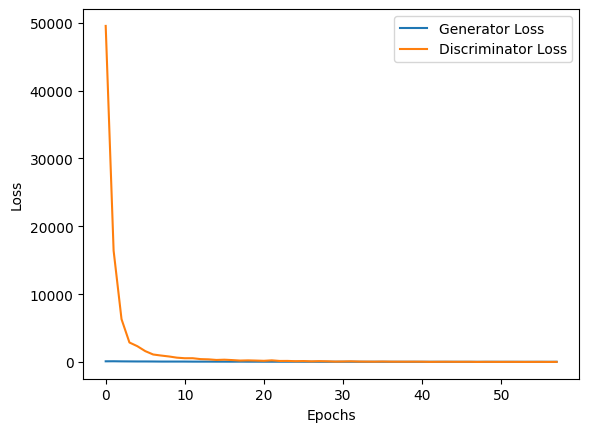

In [24]:
plt.plot(gen_total_loss, label='Generator Loss')
plt.plot(disc_loss, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

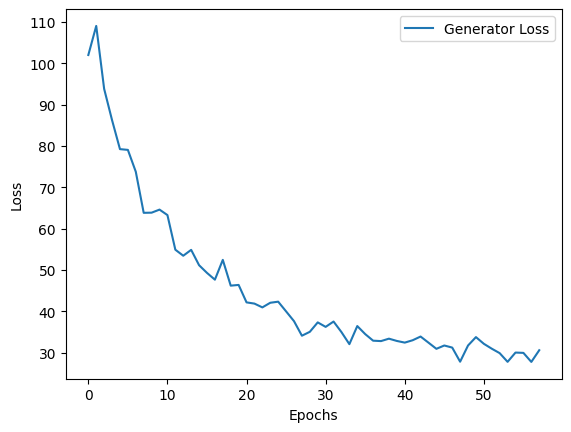

In [29]:
plt.plot(gen_total_loss, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

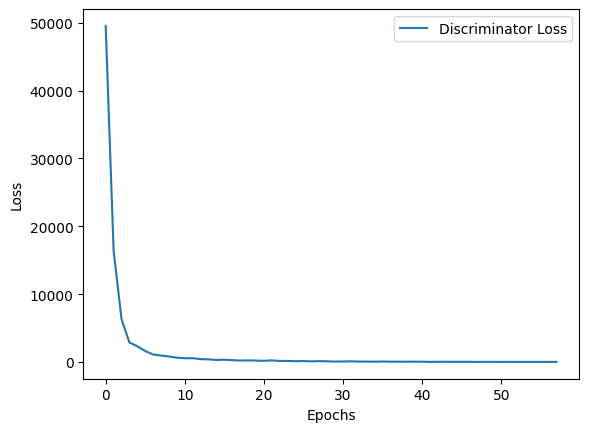

In [25]:
plt.plot(disc_loss, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


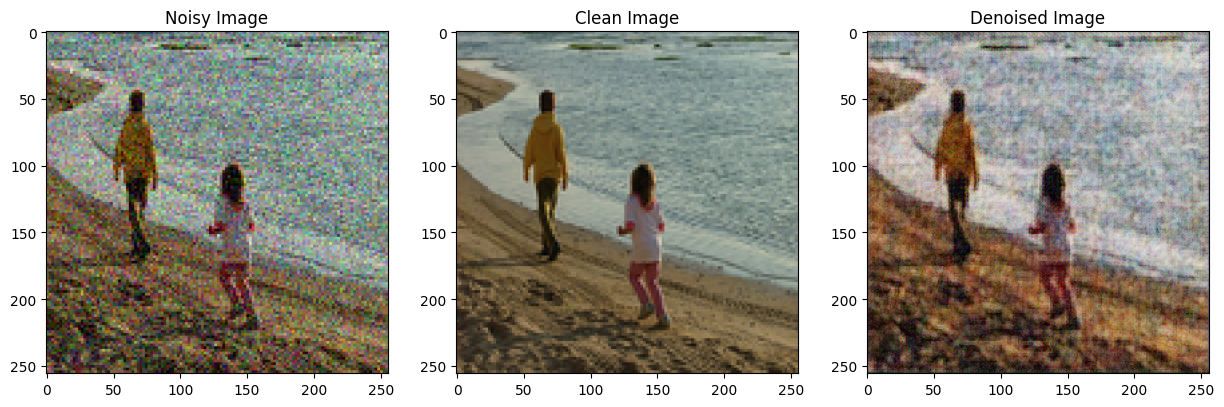

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


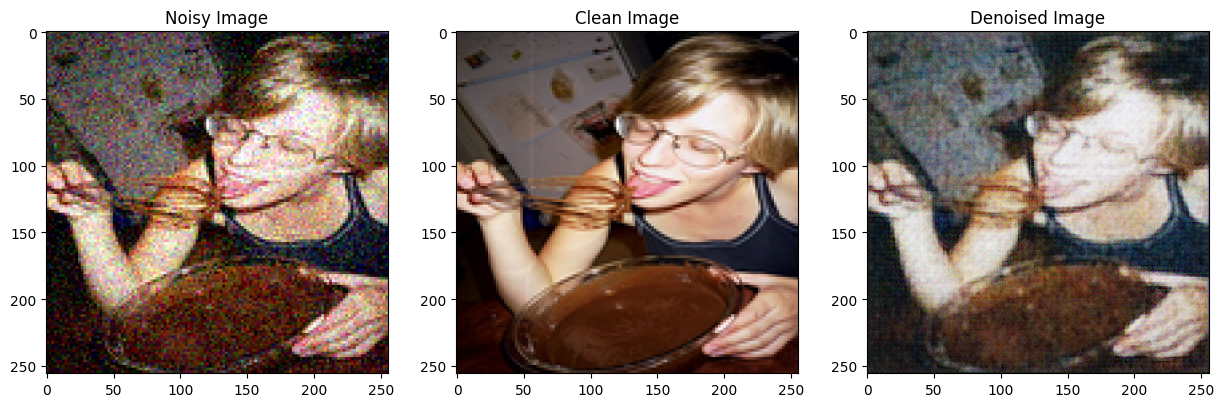

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


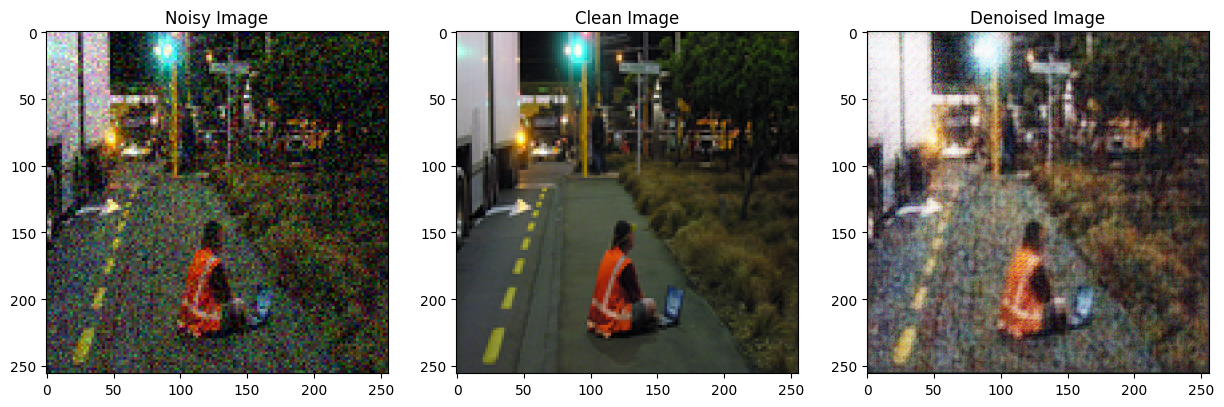

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Average PSNR: 18.470448789775215, Average MSE: 0.015207942500779406, Average SSIM: 0.42001684940596473


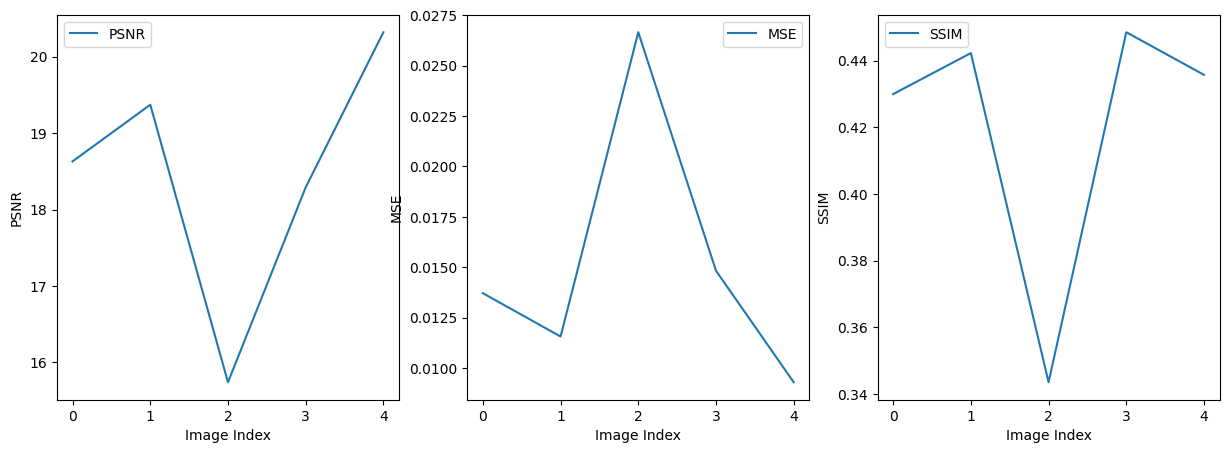

In [26]:

from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim

# Initialize lists to store PSNR, MSE, and SSIM values
psnr_values = []
mse_values = []
ssim_values = []

# Loop through all test images
for i in range(len(X_test)):
    # Ensure the input image has shape (256, 256, 3)
    test_image = X_test[i].reshape(1, 256, 256, 3)
    denoised_img = generator.predict(test_image)[0]

    # Calculate PSNR, MSE, and SSIM
    psnr_value = psnr(Y_test[i], denoised_img)
    mse_value = mse(Y_test[i], denoised_img)
    ssim_value = ssim(Y_test[i], denoised_img, multichannel=True, win_size=3, data_range=1.0)

    psnr_values.append(psnr_value)
    mse_values.append(mse_value)
    ssim_values.append(ssim_value)

    # Show denoised images for the first 3 test images
    if i < 3:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title('Noisy Image')

        plt.subplot(1, 3, 2)
        plt.imshow(Y_test[i])
        plt.title('Clean Image')

        plt.subplot(1, 3, 3)
        plt.imshow(denoised_img)
        plt.title('Denoised Image')

        plt.show()

# Print average PSNR, MSE, and SSIM values
print(f'Average PSNR: {np.mean(psnr_values)}, Average MSE: {np.mean(mse_values)}, Average SSIM: {np.mean(ssim_values)}')

# Plot PSNR, MSE, and SSIM values
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(psnr_values, label='PSNR')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_values, label='MSE')
plt.xlabel('Image Index')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ssim_values, label='SSIM')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.legend()

plt.show()


In [27]:
generator.save('/kaggle/working/gan_model_v6.h5')



In [28]:
print(os.listdir('/kaggle/working'))


['gan_model_v6.h5', '.virtual_documents']
